# Проверка гипотез по увеличению выручки в интернет-магазине. Оценка результатов AB теста

# Описание проекта
Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Задачи: приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Краткий план работы:
1) **Заргузка и предобработка данных**
2) **Приоритизация гипотез:**
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE и пояснить почему так произошло.
3) **Анализ A/B-теста:**
- Построить график кумулятивной выручки по группам.
- Построить график кумулятивного среднего чека по группам. 
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. 
- Построить график кумулятивного среднего количества заказов на посетителя по группам.
- Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 
- Построить точечный график количества заказов по пользователям. 
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. 
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
4) **Общий вывод. Принять решение по результатам теста и пояснить его. Варианты решений:**
- Остановить тест, зафиксировать победу одной из групп.
- Остановить тест, зафиксировать отсутствие различий между группами.
- Продолжить тест.

## Загрузим данные и подготовим их к анализу

In [1]:
# Для начала импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt

In [2]:
# Откроем датасеты и сохраним в переменные
try:
    visitors, orders, hypothesis = (
        pd.read_csv('visitors.csv'),  # журнал посещений
        pd.read_csv('orders.csv'),  # покупки
        pd.read_csv('hypothesis.csv'),  # гипотезы
    )
except:
    visitors, orders, hypothesis = (
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'),  # журнал посещений
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),  # покупки
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),  # гипотезы
    )

### Предобработка данных в датасете `visits`

In [3]:
visitors.head(20)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


**Краткое описание каждого столбца**
- **date** — дата
- **group** — группа A/B-теста
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

In [4]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [5]:
# Изменим тип данных
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

In [7]:
# Поиск явных дубликатов по всему датасету
visitors.duplicated().sum()

0

### Предобработка данных в датасете `orders`

In [8]:
orders.head(20)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


**Краткое описание каждого столбца**
- **transactionId** — идентификатор заказа
- **visitorId** — идентификатор пользователя, совершившего заказ
- **date** — дата, когда был совершён заказ
- **revenue** — выручка заказа
- **group** — группа A/B-теста, в которую попал заказ

In [9]:
orders = orders.rename(columns={'transactionId':'orderId', 'visitorId':'userId'})
orders.columns

Index(['orderId', 'userId', 'date', 'revenue', 'group'], dtype='object')

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   orderId  1197 non-null   int64 
 1   userId   1197 non-null   int64 
 2   date     1197 non-null   object
 3   revenue  1197 non-null   int64 
 4   group    1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
# Изменим тип данных
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
orders.dtypes

orderId             int64
userId              int64
date       datetime64[ns]
revenue             int64
group              object
dtype: object

In [13]:
# Поиск явных дубликатов по всему датасету
orders.duplicated().sum()

0

### Датасет `hypothesis`

In [14]:
pd.options.display.max_colwidth = 130

In [15]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Краткое описание каждого столбца**
- **Hypothesis** — краткое описание гипотезы;
- **Reach** — охват пользователей по 10-балльной шкале;
- **Impact** — влияние на пользователей по 10-балльной шкале;
- **Confidence** — уверенность в гипотезе по 10-балльной шкале;
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [16]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [17]:
# Посмотрим сколько у нас групп в АВ-тесте;
print(f'''Групп в АВ-тесте - {len(orders['group'].unique())}, {orders['group'].unique()}
''')

# Изучим временной интервал, узнав даты начала и окончания теста;
print(f'''Дата начала теста - {orders['date'].min().date()}
Дата окончания теста - {orders['date'].max().date()}
Длительность теста - {(orders['date'].max() - orders['date'].min()).days} дней
''')

# Рассмотрим количество пользователей в каждой группе - по таблице с заказами;
print(f'''Количество пользователей в каждой группе: 
{orders['group'].value_counts()}
''')

# Посмотрим не попадают ли какие-то пользователи в обе группы - по таблице с заказами;
unique_users = orders.groupby('userId')['group'].nunique().reset_index()
print(f'''Количество пользователей, попавших в обе группы - {len(unique_users[unique_users['group'] > 1])}
''')

Групп в АВ-тесте - 2, ['B' 'A']

Дата начала теста - 2019-08-01
Дата окончания теста - 2019-08-31
Длительность теста - 30 дней

Количество пользователей в каждой группе: 
B    640
A    557
Name: group, dtype: int64

Количество пользователей, попавших в обе группы - 58



## Приоритизация гипотез

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Посмотрим на них

In [18]:
hypothesis.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Применим фреймворк ICE для приоритизации гипотез. Отсортиртируем их по убыванию приоритета.

Воспользуемся методом приоритизации гипотез ICE, формула которой равна:

![ice.jpg](https://github.com/Islam95-86/ICE-RICE-image/blob/main/ice.jpg?raw=true)

In [19]:
def ice_method(df):
    ice_score = (df['impact'] * df['confidence']) / df['efforts']
    return round(ice_score, 2)

In [20]:
hypothesis['ice_score'] = hypothesis.apply(ice_method, axis=1)
hypothesis = hypothesis.sort_values(by='ice_score', ascending=False).reset_index(drop=True)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice_score
0,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


В тройке лидеров закрепились следующие гипотезы:
- 1 гипотеза: Запустить акцию, дающую скидку на товар в день рождения
- 2 гипотеза: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 3 гипотеза: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Воспользуемся методом приоритизации гипотез RICE, формула которой равна:

![rice.jpg](https://github.com/Islam95-86/ICE-RICE-image/blob/main/rice.png?raw=true)

In [21]:
def rice_method(df):
    rice_score = (df['reach'] * df['impact'] * df['confidence']) / df['efforts']
    return round(rice_score, 2)

In [22]:
hypothesis['rice_score'] = hypothesis.apply(rice_method, axis=1)
hypothesis = hypothesis.sort_values(by='rice_score', ascending=False).reset_index(drop=True)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
4,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


В тройке лидеров закрепились следующие гипотезы:
- 1 гипотеза: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2 гипотеза: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 3 гипотеза: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

### Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE и поясним почему так произошло.

Так как в формуле для подсчета **ICE** ключевую роль играют "уверенность в успехе гипотезы" и "влияние на пользователей от этих нововведений", и их отношение к "затратам ресурсов на проверку гипотез", то лидерами стали вышеуказанные гипотезы, в виду наименьших, по сравнению с другими, издержек ресурсов на проверку гипотезы.

С добавление нового параметра, а именно "охвата пользователей", в формуле для подсчета **RICE**, ситуация немного приобразилась. Призеры предыдущего  списка также занимают лидерство и в этом, что вселяет уверенность в правильности приоритизации, но в тройку попала гипотеза, которая занимала 5-ое место в списке по приоритизации по методу **ICE**. Параметр **reach** играет важную роль в приоритизации, если не учитывать охват пользователей, то даже эффективные, имеющие сильное влияние на пользователей гипотезы будут иметь наименьшую результативность.

## Анализ A/B-теста

**Сформулируем задачи для анализа A/B-теста и будем отвечать на них последовательно:**
- Построить график кумулятивной выручки по группам.
- Построить график кумулятивного среднего чека по группам. 
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. 
- Построить график кумулятивного среднего количества заказов на посетителя по группам.
- Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 
- Построить точечный график количества заказов по пользователям. 
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. 
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 


- **Принять решение по результатам теста и пояснить его. Варианты решений:**
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### Построить график кумулятивной выручки по группам.

In [23]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 
                                           'userId' : 'nunique', 'revenue' : 'sum'}), 
                                     axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), 
                                       axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


In [24]:
print(cumulativeData['date'].min() == orders['date'].min())
print(cumulativeData['date'].max() == orders['date'].max())

True
True


Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

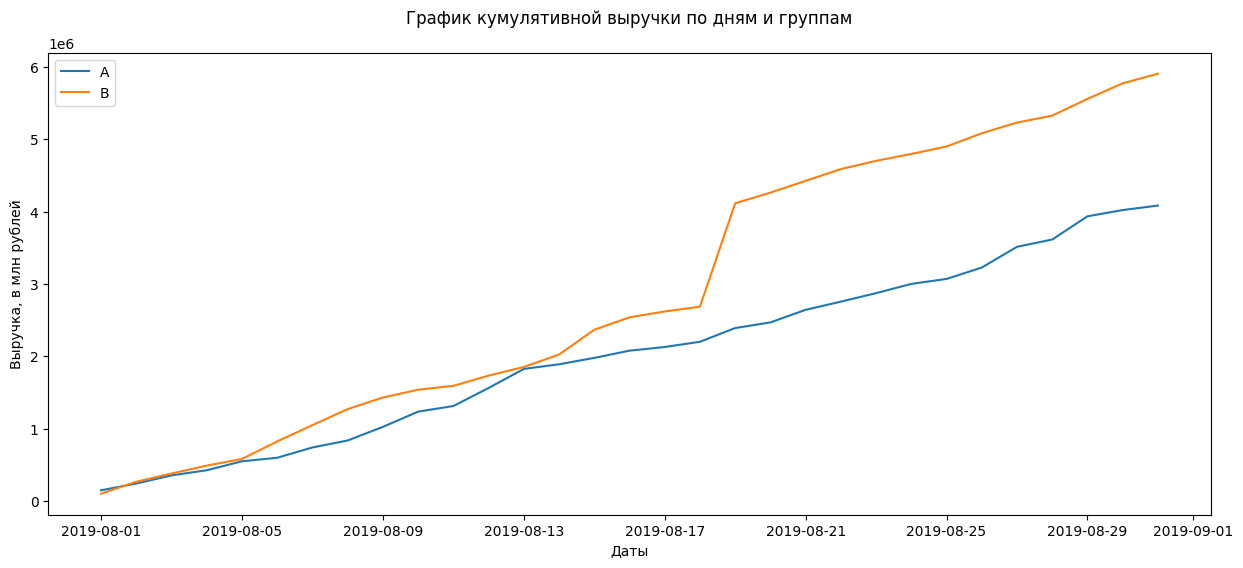

In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig, ax = plt.subplots(figsize=(15,6))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по дням и группам\n')
plt.xlabel('Даты')
plt.ylabel('Выручка, в млн рублей');

Выручка почти равномерно увеличивается в течении всего теста, за исключением резкого непродолжительного подъема для группы **`В`** в промежутке между датами `2019-08-17` и `2019-08-21`, что может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### Построить график кумулятивного среднего чека по группам. 

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

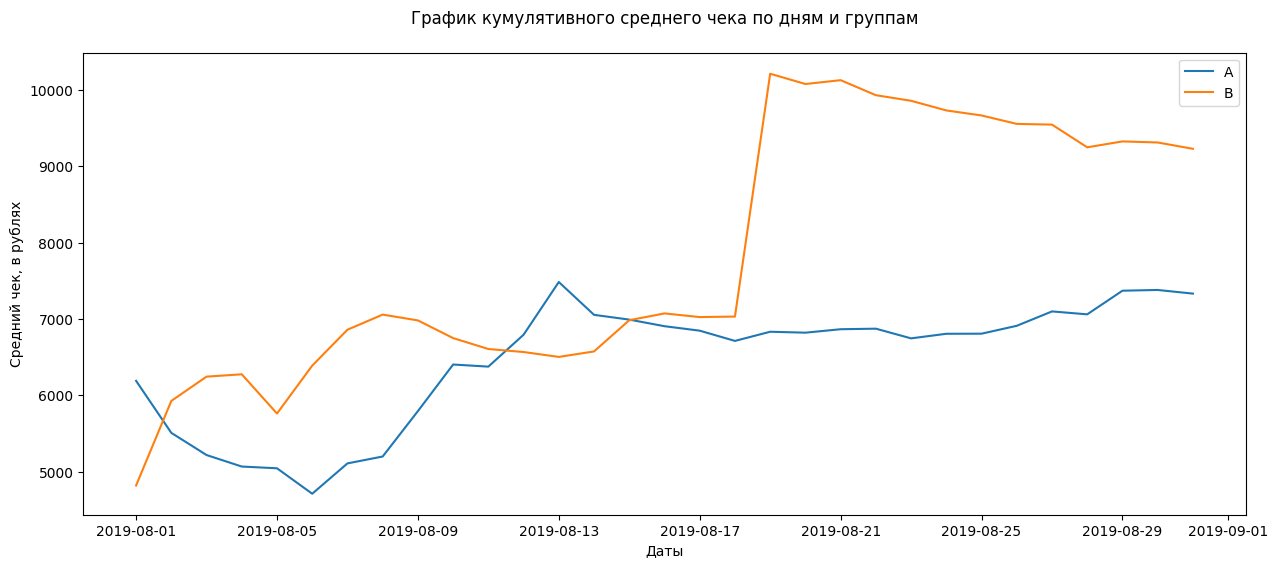

In [26]:
fig, ax = plt.subplots(figsize=(15,6))                       
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по дням и группам\n')
plt.xlabel('Даты')
plt.ylabel('Средний чек, в рублях');

Явное различие между группами **`А`** и **`В`**, но резкие, временные подъемы и спады характерны для обоих групп. График для группы **`А`** имеет спад с начала теста и имеет такую тенденцию на протяжении 5-7 дней, следом идет такой же резкий подъем с такой же продолжительностью и становится равномерным ближе к концу теста. График для группы **`В`** более кривой и неравномерный, и ближе к концу теста имеет спад. Возможные причины все те же, в увеличении числа заказов, либо в наличии крупных заказов.

<a id='3.3'></a>

### Построить график относительного изменения кумулятивного среднего чека группы `B` к группе `A`.  

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline()

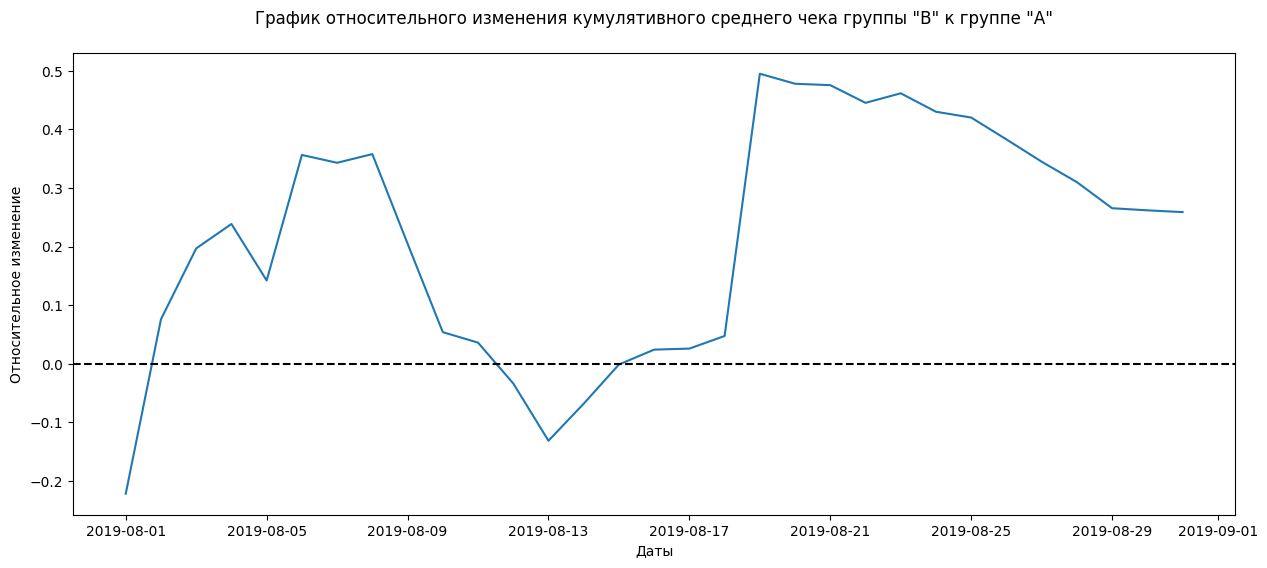

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

fig, ax = plt.subplots(figsize=(15,6))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы "B" к группе "A"\n')
plt.xlabel('Даты')
plt.ylabel('Относительное изменение'); 

В нескольких точках график различия между сегментами резко «скачет», что свидетельствует о наличии крупных заказов и выбросов.

### Построить график кумулятивного среднего количества заказов на посетителя по группам.

Аналогично проанализируем график кумулятивной конверсии.

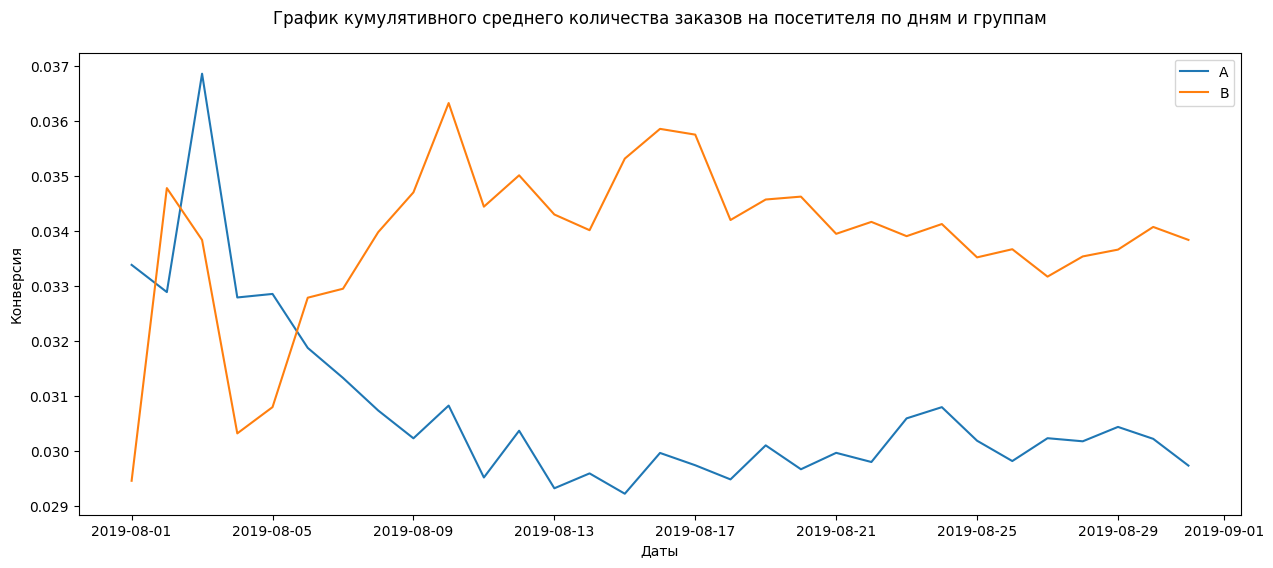

In [28]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

fig, ax = plt.subplots(figsize=(15,6))
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по дням и группам\n')
plt.xlabel('Даты')
plt.ylabel('Конверсия');

С начала теста конверсия конверсия группы **`A`** была выше, чем у группы **`В`** и достигла своего пика в начале августа 2019 года, далее идет спад и график ближе к середине месяца имеет более равномерный вид. График для группы **`В`** имеет резкий подъем и такой же резкий спад в первых числах августа; основательный подъем начинается в 4-5 числах этого месяца и ближе к концу исследования принимает равномерную структуру. По результатам выведенного графика можно сделать вывод: конверсия группы **`В`** значительно лучше показывает себя, нежели конверсия группы **`А`**

<a id='3.5'></a>

### Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы `B` к группе `A`.  

Построим график относительного различия кумулятивных конверсий:

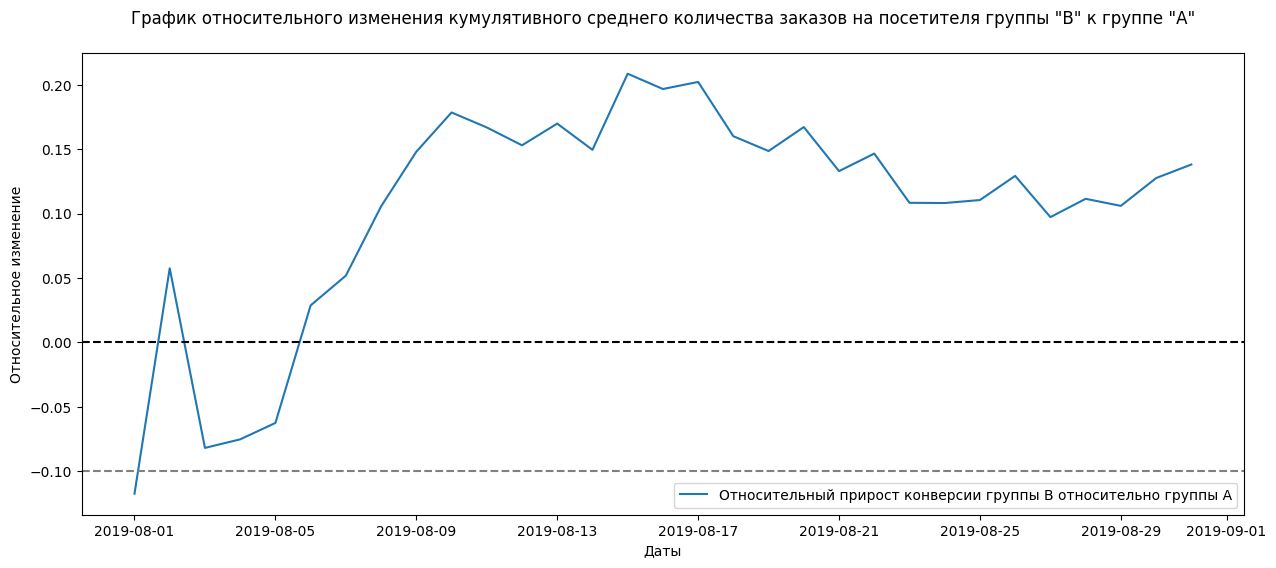

In [29]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']], left_on='date', 
                                      right_on='date', how='left', suffixes=['A', 'B']))

fig, ax = plt.subplots(figsize=(15,6))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы "B" к группе "A"\n')
plt.xlabel('Даты')
plt.ylabel('Относительное изменение'); 

В начале теста группа **`B`** проигрывала группе **`A`**, а затем вырвалась вперёд; далее опять спад, но следующий подъем уже окончательно закрепил лидирующее место группы **`B`**.

### Построить точечный график количества заказов по пользователям. 

Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [30]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Есть пользователи, которые совершали 5, 8, 9 и 11 заказов. Значительно больше, чем среднестатистический пользователь в данном исследовании.

Построим точечную диаграмму числа заказов на одного пользователя:

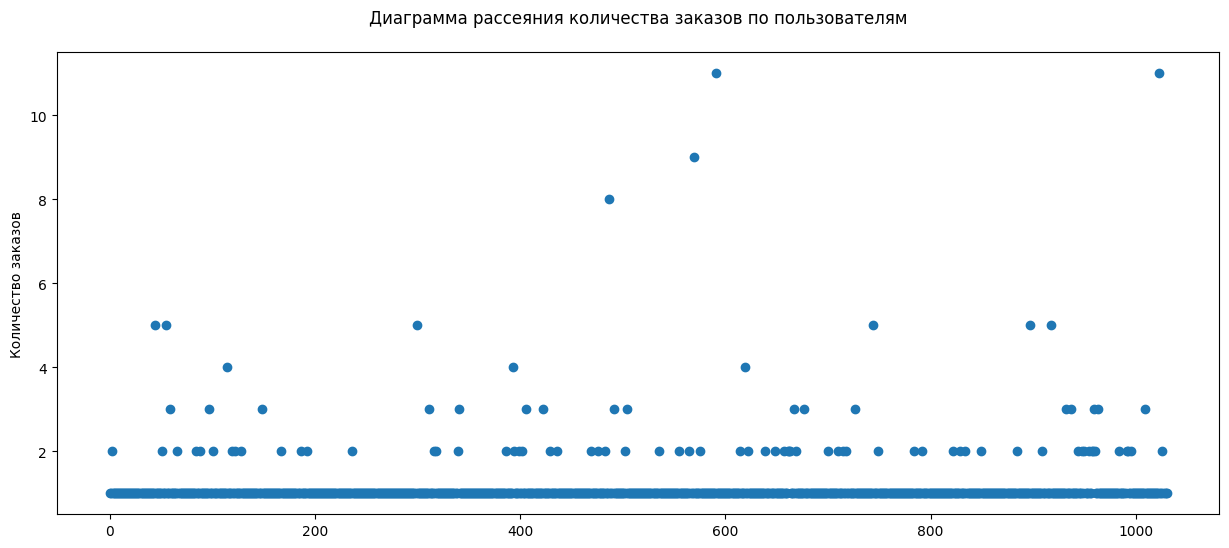

In [31]:
x_values = pd.Series(range(0,len(ordersByUsers)))

fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Диаграмма рассеяния количества заказов по пользователям\n')
plt.ylabel('Количество заказов'); 

Выводы верны: много пользователей с 2-4 заказами. 

### Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [32]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Около 5% пользователей оформляли больше 2-ух заказов; 10% пользователей заказывали более одного раза. 
Разумно выбрать 3 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Построить точечный график стоимостей заказов. 

Построим точечную диаграмму распределения стоимостей заказов: 

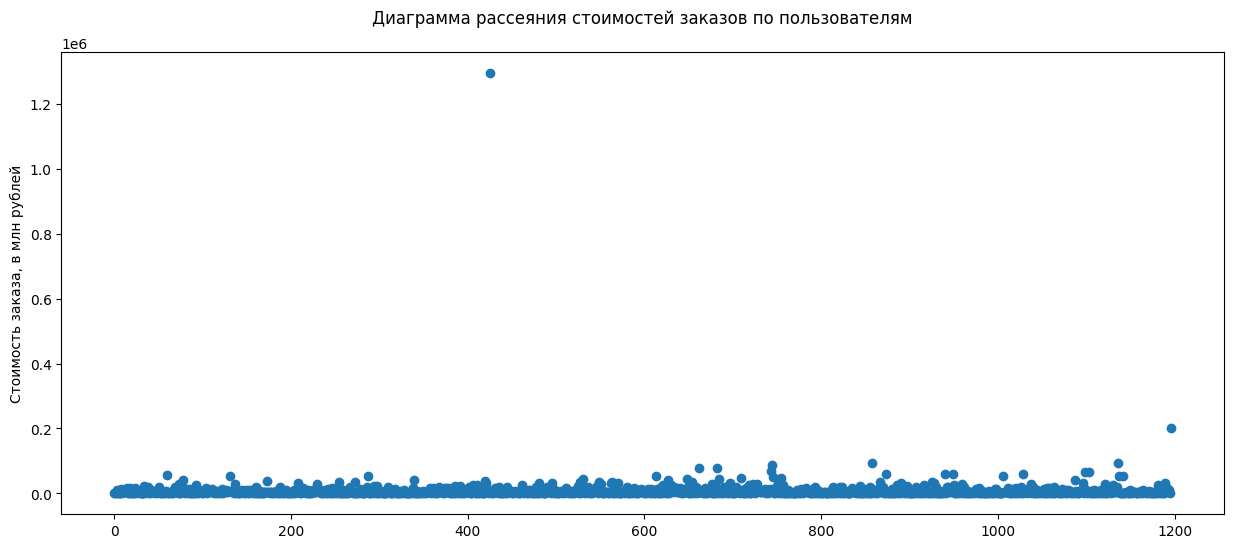

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))

fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма рассеяния стоимостей заказов по пользователям\n')
plt.ylabel('Стоимость заказа, в млн рублей'); 

Как видно на графике, наличие дорогих заказов подтверждается. Есть даже заказ с суммарной стоимостью больше 1 200 000 рублей. Уменьшим масштаб по оси `y` для наглядности.

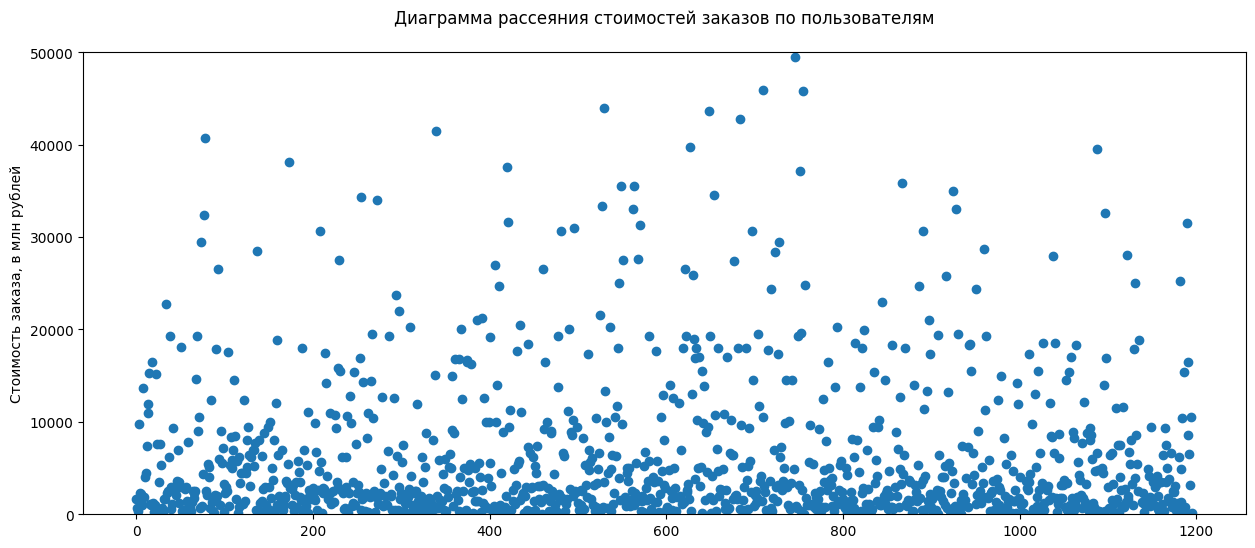

In [34]:
fig, ax = plt.subplots(figsize=(15,6))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма рассеяния стоимостей заказов по пользователям\n')
plt.ylabel('Стоимость заказа, в млн рублей')
plt.ylim(0, 50000);

По графику можно выбрать границу аномальных заказов между 20 000 и 40 000 рублей, однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. 

### Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

In [35]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. 
За верхнюю границу суммы заказа можно обозначить цену равную 30-35 000 рублей.
 

### Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Начнём с подготовки данных

In [36]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

data = (visitorsADaily.merge(visitorsBDaily, left_on='date', right_on='date', how='left'))

print(data.head())

        date  visitorsPerDateA  visitorsPerDateB
0 2019-08-01               719               713
1 2019-08-02               619               581
2 2019-08-03               507               509
3 2019-08-04               717               770
4 2019-08-05               756               707


**Напомним названия столбцов данных:**
- **date** — дата;
- **visitorsPerDateA** — количество пользователей в выбранную дату в группе A;
- **visitorsPerDateB** — количество пользователей в выбранную дату в группе B;

Создадим переменные **ordersByUsersA** и **ordersByUsersB** со столбцами `['userId', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

Объявим переменные **sampleA** и **sampleB**, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [37]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA']
                                                                            .sum() - len(ordersByUsersA['orders']))
                                                         ,name='orders',),],axis=0,)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB']
                                                                            .sum() - len(ordersByUsersB['orders']))
                                                         ,name='orders',),],axis=0,)



Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя используя проверку критерием Манна-Уитни и относительный прирост среднего числа заказов группы **`B`**, поделив среднее число заказов группы **`B`** на среднее число заказов группы **`A`** - 1.

Сформулируем гипотезы:
- Нулевая гипотеза: различий в среднем числе заказов между группами нет. 
- Альтернативная гипотеза: различия в среднем числе заказов между группами есть.

In [38]:
print("Значение p-value - {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B - {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Значение p-value - 0.017
Относительный прирост среднего числа заказов группы B - 0.138


Вывод: По «сырым» данным различия в среднем числе заказов между группами **`A и B`** присутствуют. 

p-value = 0.017 меньше 0.05, что означает, что нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Что касается относительного прироста среднего числа заказов между группами, то группа **`B`** больше группы **`А`** на 14%.

### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами:

In [39]:
print('Значение p-value - {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B - {0:.3f}'.format(orders[orders['group']=='B']['revenue']
                       .mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Значение p-value - 0.729
Относительный прирост среднего чека группы B - 0.259


P-value значительно больше 0.05 - 0.729. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы **`B`** значительно выше среднего чека группы **`A`**, аж, на 26%, **но стоит уточнить, что даже при таком относительном различии среднего чека между группами, наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно.**

### Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Вспомним, что из результатов нахождения перцентилей для средних чеков и количества заказов на одного пользователя, мы условились считать аномалиями пользователей, заказавших более 3 заказов или оформивших заказ на сумму более 35 000 рублей.

Сделаем срезы пользователей с числом заказов больше 3 — **usersWithManyOrders** и пользователей, совершивших заказы дороже 35 000 — **usersWithExpensiveOrders**. Объединим их в таблице **abnormalUsers**

In [40]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
# узнаем, сколько всего аномальных пользователей атрибутом shape
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
Name: userId, dtype: int64
42


42 аномальных пользователя.

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [41]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId']
                                                           .isin(abnormalUsers))]['orders']
                             ,pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(
                                 ordersByUsersA['orders'])), name='orders',),], axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId']
                                                           .isin(abnormalUsers))]['orders']
                             ,pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(
                                 ordersByUsersB['orders'])), name='orders',),], axis=0,) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [42]:
print('Значение p-value - {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B - {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Значение p-value - 0.014
Относительный прирост среднего числа заказов группы B - 0.155


Результаты по среднему количеству заказов практически не изменились. p-value = 0.014, также меньше 0.05. Относительный прирост увеличился, теперь различие составляет 15,5% в пользу группы **`B`**.

### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [43]:
print(
    'Значение p-value - {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "относительный прирост среднего чека группы B - {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Значение p-value - 0.874
относительный прирост среднего чека группы B - 0.025


P-value увеличился - 0.874, но разница между сегментами сократилась до 2,5%. Хотя общие выводы по результатам теста не изменились, но влияние аномалий на числовые результаты видны сразу.

## Общий вывод. Принять решение по результатам теста и пояснить его.

Какие выводы по тесту можем сделать?

Имеющиеся факты:
- Есть статистически значимые различия по среднему количеству заказов между группами по «сырым»(p-value = 0.017) и отфильтрованным(p-value = 0.014) данным
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым»(p-value = 0.729), ни по данным после фильтрации аномалий(p-value = 0.874)
- График различия среднего количества заказов между группами [3.5](#3.5) сообщает, что результаты группы **`B`** лучше группы **`А`**, а равномерная структура графика в конце теста подтверждает выведенные результаты; различие составляет около 15% в пользу группы **`B`**
- График различия среднего чека [3.3](#3.3) говорит о том, что результаты группы **`B`** лучше и, не смотря на спад, различие составляет около 30% в пользу группы **`B`**

**Исходя из вышеперечисленных фактов и имеющихся результатов, можно принять решение об остановке теста и признания победы группы `B`.**